## Precompute spectrograms for input to hawkears model and for quicker training cycles
The aim of this notebook is to develop a method for exporting the dataset  of spectrograms to disk. 

Additionally, it provides a method to get back from a pre-computed spectrogram to the original audio file on disk.

Finally, it saves the 3s audio clips to disk too. 


In [1]:
from pathlib import Path
import pandas as pd
import sys
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import take_sample
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
import torch
import glob
import matplotlib.pyplot as plt
import hashlib

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load the dataframe from disk

In [2]:
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "processed" / "train_set"
df_train: pd.DataFrame = pd.read_pickle(train_df_path / "train_set.pkl")
df_train.head(2)

,Unnamed: 0,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,...,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1,1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87956,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac
2,1758,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87898,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac


## Set the output paths


In [3]:
train_present_save_path = Path.joinpath(data_path, "processed", "spectrograms", "train", "present")
train_absent_save_path = Path.joinpath(data_path, "processed", "spectrograms", "train", "absent")
valid_present_save_path = Path.joinpath(data_path, "processed", "spectrograms", "valid", "present")
valid_absent_save_path = Path.joinpath(data_path, "processed", "spectrograms", "valid", "absent")

save_paths = [train_present_save_path, train_absent_save_path, valid_present_save_path, valid_absent_save_path]
for path in save_paths:
    path.mkdir(parents=True, exist_ok=True)

Take a sample of the dataframe by recording.


In [25]:
sample_frac = 1.0
df_train_sample = take_sample(df_train, sample_frac, seed=42)

sampled 54416 recordings from the original 54416 


In [26]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
string_to_hash = ''.join(pd.util.hash_pandas_object(df_train_sample, index=False).astype(str))

# Use hashlib to create a hash of the entire DataFrame
hash_value = hashlib.sha256(string_to_hash.encode()).hexdigest()
print(hash_value)

8e6b299fe1de3a46a75990afe71bcd4ac703b00db475f816ef8b7436e62ac58d


In [27]:
assert hash_value == "f65bcbf7f1362a9907a26e50d23956d8411d5570a2cd8ec57a921703c7e9e280", "The dataframe has changed"

AssertionError: The dataframe has changed

# Turn the DataFrame into an AudioFileDataset
This uses the process in build.py to generate clip start and finish times for each of the downloaded recordings, and pairs the clips with their corresponding labels. No splitting of the audio is done here. A different train and validation set are generated each time the function is called. 

70 not downloaded
downloading 0 clips
skipped 0 previously downloaded files

--------------------------------------------------
before filtering undefined clips
recordings per task method = 
 task_method
1SPT    207551
1SPM     74805
None     44385
Name: count, dtype: int64
total recordings = 326741

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                  2009.0         13236.0
1SPT                  2483.0         38530.0
NaN                    762.0          3262.0
total target clips =  5254
total absence clips =  55028
total available human labelled target tags = 4204
undefined 266459

--------------------------------------------------
after filtering undefined clips
recordings per task method = 
 task_method
1SPT    41013
1SPM    15245
None     4024
Name: count, dtype: int64
total recordings = 60282

Tags generated from each tagging method:
             target_presence  target_absence
ta

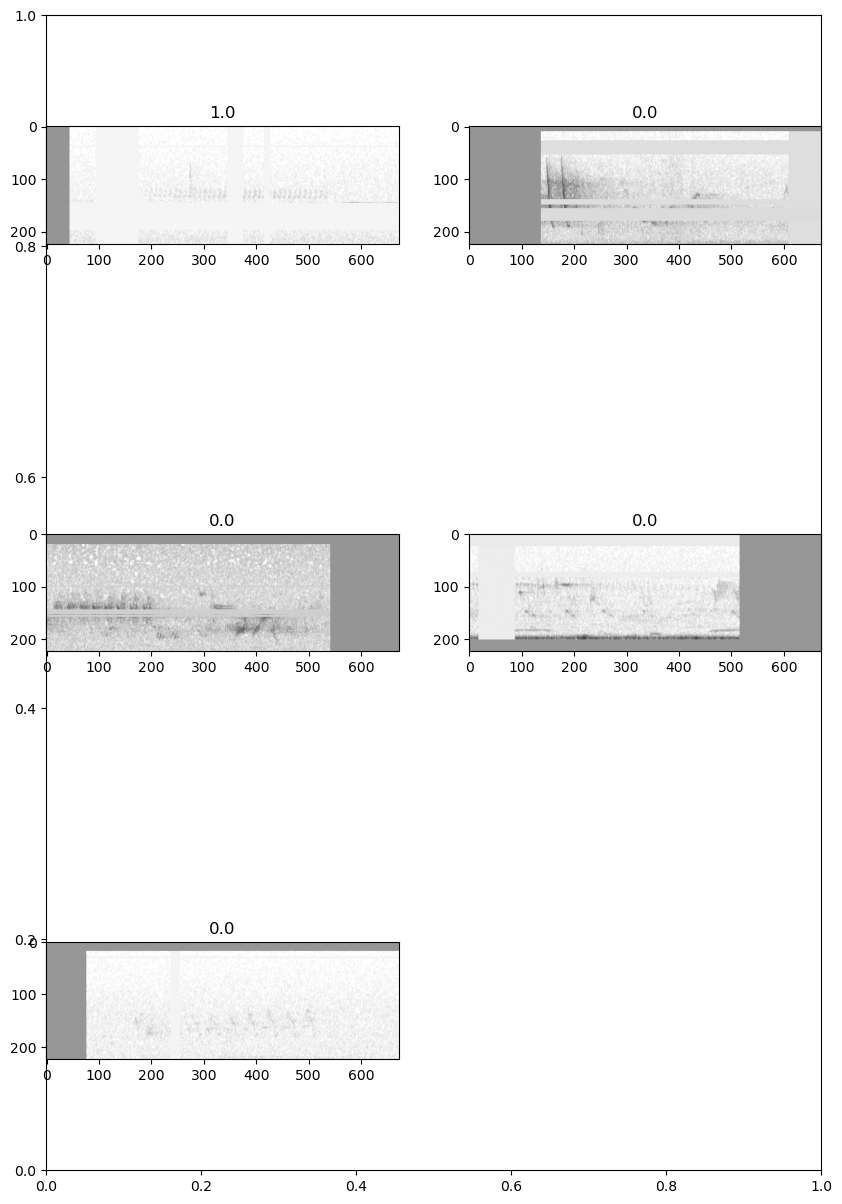

In [28]:
target_species = "OSFL"
train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(df_train_sample, target_species = target_species, download_n = 0, one_class=False)

# Save the split (AudioFile) datasets to disk

In [22]:
data_path / 'interim' / 'train_and_valid_set'

PosixPath('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/interim')

In [24]:
pd.to_pickle(valid_dataset.label_df, data_path / 'interim' / 'train_and_valid_set' / f'valid_ds_sample_size_{sample_frac}.pkl')
pd.to_pickle(train_dataset.label_df, data_path / 'interim' / 'train_and_valid_set' / f'train_ds_sample_size_{sample_frac}.pkl')

# Downsample the absent class
We have access to much more data from the absent class than from the presence class, so downsampling allows the model to see more of the data from the presence class. 

In [8]:
def downsample_absent_class(ds: opso.AudioFileDataset):
    n_present = int(ds.class_counts()[1][0])
    ds.label_df = opso.data_selection.resample(ds.label_df, n_present, random_state=42)
downsample_absent_class(train_dataset)
downsample_absent_class(valid_dataset)
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([419., 419.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([101., 101.])))

# Make datasets of presence and absence clips. 

In [9]:
train_present_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==1.0]
train_absent_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==0.0]
valid_present_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==1.0]
valid_absent_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==0.0]

datasets = [train_present_ds, train_absent_ds, valid_present_ds, valid_absent_ds]

# Delete existing spectrograms if there are any

In [12]:
input(f"Warning, this will delete the files contained in {save_paths}.")
for ds, save_path in zip(datasets, save_paths):
    for file in save_path.iterdir():
        file.unlink()

# save the datasets as tensor spectrograms. 

In [13]:
def precompute_spectrograms(datasets, save_paths):
    for ds, save_path in zip(datasets, save_paths):
        for clip_index in ds.index:
            clip_path, start, end = clip_index
            filename = clip_path.parts[-1] + "-" + str(start) + "-" + str(end) + "-.pkl"
            audio = Audio.from_file(clip_path, offset=start, duration=end-start)
            spec = Spectrogram.from_audio(audio)
            im = spec.to_image(invert=False, return_type='torch')
            torch.save(im, save_path.joinpath(filename))
precompute_spectrograms(datasets, save_paths)

# Define a function to get from the spectrogram back to the original audio file

In [90]:

def spec_to_audio(spec_filename, audio_path):
    '''
    Utility function to get from a precomputed spectrogram back to the same segment of the audio file.

    The filename of the spectrogram is used.
    Filename format:
    recording-<recording_id>.<file_extension>-<offset>-<end>-.pkl
    Example filename: 
    recording-4429.mp3-12.0-15.0-.pkl

    Args:
        spec_filename (str): filename of the spectrogram
        audio_path (str): path to the audio files
    Returns:
        path (str): path to the source audio file
        offset (float): offset in seconds from beginning of the recording
        duration (str): duration of the clip in seconds.
'''
    _, rec_file, offset, end, _ = spec_filename.split("-")
    duration = float(end) - float(offset)
    path = Path(f"{audio_path}/recording-{rec_file}")
    return path, float(offset), duration

In [91]:
counter = 0

# Look at spectrograms in the training set

COUNT 0


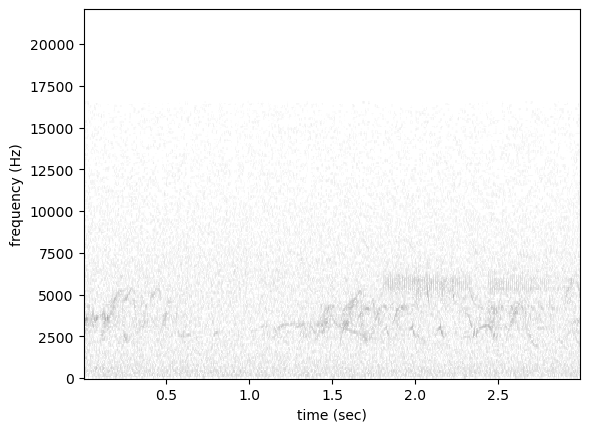

<Audio(samples=(132300,), sample_rate=44100)>

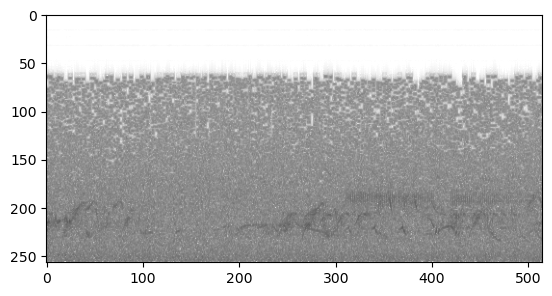

In [92]:
spec_path = train_present_save_path
spectrogram_file_paths = glob.glob(str(spec_path) + "/*")
spectrogram_file_names = [Path(p).parts[-1] for p in spectrogram_file_paths]

audio_path = train_present_ds.index[0][0].parent

print("COUNT " + str(counter))
counter+=1

path, start, duration = spec_to_audio(spec_filename=spectrogram_file_names[counter], audio_path=audio_path)

audio = Audio.from_file(path, offset=start, duration=duration)
spec = Spectrogram.from_audio(audio)
spec.plot() 
tensor = torch.load(spectrogram_file_paths[counter])
show_tensor(tensor)
audio




# Look at spectrograms in the validation set

COUNT 1


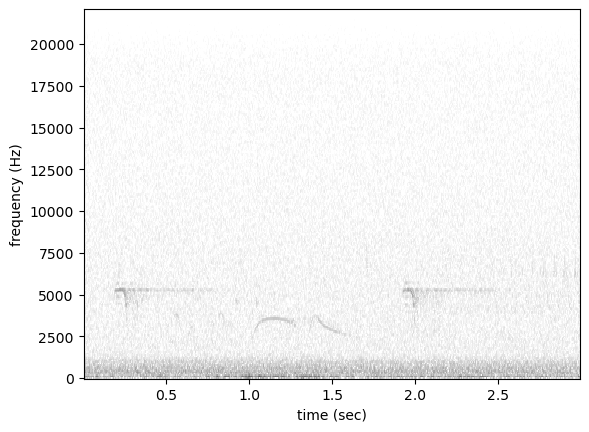

<Audio(samples=(132300,), sample_rate=44100)>

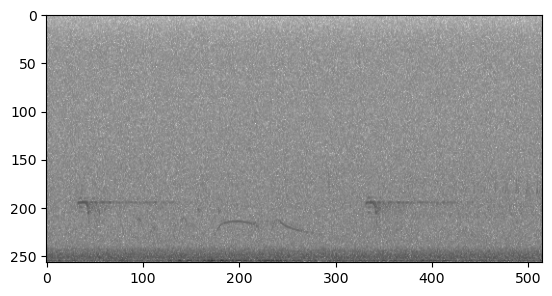

In [93]:
spec_path = valid_present_save_path
spectrogram_file_paths = glob.glob(str(spec_path) + "/*")
spectrogram_file_names = [Path(p).parts[-1] for p in spectrogram_file_paths]

audio_path = train_present_ds.index[0][0].parent

print("COUNT " + str(counter))
counter+=1

path, start, duration = spec_to_audio(spec_filename=spectrogram_file_names[counter], audio_path=audio_path)

audio = Audio.from_file(path, offset=start, duration=duration)
spec = Spectrogram.from_audio(audio)
spec.plot() 
tensor = torch.load(spectrogram_file_paths[counter])
show_tensor(tensor)
audio


### In a sampled down training set of 388 samples, I listened to all of the presence clips and looked at the spectrograms, and confirmed the presence of 312 olive sided flycatcher calls out of 388. 

This means that 20% of the recall difference could be due to mis-labelled data. 

(PosixPath('../../data/raw/recordings/OSFL/recording-100730.flac'), 151.5, 3.0)
This spectrogram had some cool features in it. 

#  Investigate one specific audio clip

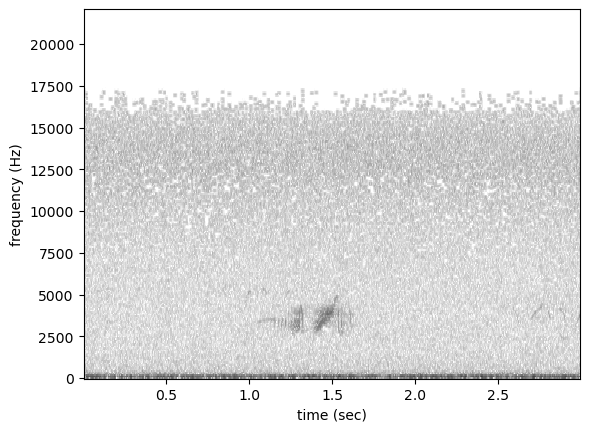

In [94]:
clip = Audio.from_file("/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/audio_clips/valid/present/00783-150.0-153.0-recording-48527.mp3")
spec = Spectrogram.from_audio(clip)
spec.plot()

In [95]:
clip

<Audio(samples=(132300,), sample_rate=44100)>

# test the amplitude plot function


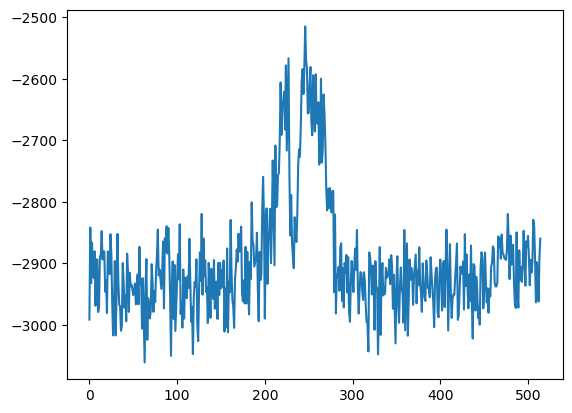

In [96]:
plt.plot(spec.amplitude(freq_range=(2500, 5500)))

In [97]:
# Generate an audio clips dataset
train_present_save_path = Path.joinpath(data_path, "processed", "audio_clips", "train", "present")
train_absent_save_path = Path.joinpath(data_path, "processed", "audio_clips", "train", "absent")
valid_present_save_path = Path.joinpath(data_path, "processed", "audio_clips", "valid", "present")
valid_absent_save_path = Path.joinpath(data_path, "processed", "audio_clips", "valid", "absent")

save_paths = [train_present_save_path, train_absent_save_path, valid_present_save_path, valid_absent_save_path]
for path in save_paths:
    path.mkdir(parents=True, exist_ok=True)

# Delete existing audio files if there are any

In [98]:
input(f"Warning, this will delete the files contained in {save_paths}.")
for ds, save_path in zip(datasets, save_paths):
    for file in save_path.iterdir():
        file.unlink()

# Save Some audio files

In [99]:
def save_audio_clips(datasets, save_paths):
    file_idx = 0


    for ds, save_path in zip(datasets, save_paths):
        for clip_index in ds.index:
            clip_path, start, end = clip_index
            file_idx +=1
            str_file_index = str(file_idx).zfill(5)
            filename = str_file_index + "-" + str(start) + "-" + str(end) + "-" + clip_path.parts[-1]
            audio = Audio.from_file(clip_path, offset=start, duration=end-start)
            audio.save(save_path.joinpath(filename))
            print(filename)
save_audio_clips(datasets, save_paths)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00001-30.0-33.0-recording-4429.mp3
00002-139.5-142.5-recording-4429.mp3
00003-123.0-126.0-recording-4819.mp3
00004-9.0-12.0-recording-4921.flac
00005-63.0-66.0-recording-4921.flac
00006-123.0-126.0-recording-4921.flac
00007-51.0-54.0-recording-4928.flac
00008-73.5-76.5-recording-4928.flac
00009-123.0-126.0-recording-4928.flac
00010-0.0-3.0-recording-40330.mp3
00011-61.5-64.5-recording-40330.mp3
00012-63.0-66.0-recording-40330.mp3
00013-150.0-153.0-recording-48527.mp3
00014-9.0-12.0-recording-48543.mp3
00015-61.5-64.5-recording-48543.mp3
00016-121.5-124.5-recording-48543.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00017-40.5-43.5-recording-70890.mp3
00018-108.0-111.0-recording-97976.mp3
00019-79.5-82.5-recording-97985.mp3
00020-81.0-84.0-recording-97985.mp3
00021-1.5-4.5-recording-99092.mp3
00022-61.5-64.5-recording-99092.mp3
00023-121.5-124.5-recording-99092.mp3
00024-138.0-141.0-recording-100132.mp3
00025-6.0-9.0-recording-100138.flac
00026-63.0-66.0-recording-100138.flac
00027-118.5-121.5-recording-100138.flac
00028-120.0-123.0-recording-100138.flac
00029-31.5-34.5-recording-100329.mp3
00030-124.5-127.5-recording-100329.mp3
00031-45.0-48.0-recording-103813.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00032-66.0-69.0-recording-103813.mp3
00033-120.0-123.0-recording-103813.mp3
00034-168.0-171.0-recording-103884.mp3
00035-6.0-9.0-recording-104311.mp3
00036-7.5-10.5-recording-104311.mp3
00037-64.5-67.5-recording-104311.mp3
00038-130.5-133.5-recording-104311.mp3
00039-0.0-3.0-recording-104316.mp3
00040-61.5-64.5-recording-104316.mp3
00041-123.0-126.0-recording-104316.mp3
00042-31.5-34.5-recording-144812.mp3
00043-94.5-97.5-recording-144812.mp3
00044-60.0-63.0-recording-168948.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00045-126.0-129.0-recording-168948.mp3
00046-127.5-130.5-recording-168948.mp3
00047-141.0-144.0-recording-169644.flac
00048-142.5-145.5-recording-169644.flac
00049-6.0-9.0-recording-186920.mp3
00050-141.0-144.0-recording-218519.flac
00051-142.5-145.5-recording-218519.flac
00052-1.5-4.5-recording-255454.mp3
00053-3.0-6.0-recording-255454.mp3
00054-4.5-7.5-recording-255454.mp3
00055-6.0-9.0-recording-255454.mp3
00056-7.5-10.5-recording-255454.mp3
00057-9.0-12.0-recording-255454.mp3
00058-10.5-13.5-recording-255454.mp3
00059-12.0-15.0-recording-255454.mp3
00060-15.0-18.0-recording-255454.mp3
00061-18.0-21.0-recording-255454.mp3
00062-21.0-24.0-recording-255454.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00063-22.5-25.5-recording-255454.mp3
00064-24.0-27.0-recording-255454.mp3
00065-25.5-28.5-recording-255454.mp3
00066-27.0-30.0-recording-255454.mp3
00067-28.5-31.5-recording-255454.mp3
00068-30.0-33.0-recording-255454.mp3
00069-31.5-34.5-recording-255454.mp3
00070-33.0-36.0-recording-255454.mp3
00071-34.5-37.5-recording-255454.mp3
00072-37.5-40.5-recording-255454.mp3
00073-40.5-43.5-recording-255454.mp3
00074-43.5-46.5-recording-255454.mp3
00075-45.0-48.0-recording-255454.mp3
00076-48.0-51.0-recording-255454.mp3
00077-49.5-52.5-recording-255454.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00078-52.5-55.5-recording-255454.mp3
00079-54.0-57.0-recording-255454.mp3
00080-57.0-60.0-recording-255454.mp3
00081-58.5-61.5-recording-255454.mp3
00082-0.0-3.0-recording-255544.flac
00083-1.5-4.5-recording-255544.flac
00084-6.0-9.0-recording-255544.flac
00085-10.5-13.5-recording-255544.flac
00086-18.0-21.0-recording-255544.flac
00087-22.5-25.5-recording-255544.flac
00088-25.5-28.5-recording-255544.flac
00089-30.0-33.0-recording-255544.flac
00090-33.0-36.0-recording-255544.flac
00091-34.5-37.5-recording-255544.flac
00092-37.5-40.5-recording-255544.flac
00093-42.0-45.0-recording-255544.flac
00094-46.5-49.5-recording-255544.flac
00095-54.0-57.0-recording-255544.flac
00096-57.0-60.0-recording-255544.flac
00097-58.5-61.5-recording-255544.flac
00098-130.5-133.5-recording-277670.mp3
00099-15.0-18.0-recording-280076.mp3
00100-0.0-3.0-recording-291496.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00101-295.5-298.5-recording-291508.mp3
00102-0.0-3.0-recording-291576.mp3
00103-1.5-4.5-recording-291576.mp3
00104-15.0-18.0-recording-291584.mp3
00105-12.0-15.0-recording-291593.mp3
00106-27.0-30.0-recording-291600.mp3
00107-40.5-43.5-recording-291624.mp3
00108-0.0-3.0-recording-291663.mp3
00109-1.5-4.5-recording-291663.mp3
00110-235.5-238.5-recording-291730.mp3
00111-7.5-10.5-recording-291859.mp3
00112-79.5-82.5-recording-291957.mp3
00113-81.0-84.0-recording-291957.mp3
00114-28.5-31.5-recording-292035.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00115-36.0-39.0-recording-292039.mp3
00116-51.0-54.0-recording-292071.mp3
00117-52.5-55.5-recording-292071.mp3
00118-12.0-15.0-recording-292159.mp3
00119-13.5-16.5-recording-292159.mp3
00120-1.5-4.5-recording-292160.mp3
00121-61.5-64.5-recording-292160.mp3
00122-6.0-9.0-recording-292165.mp3
00123-0.0-3.0-recording-292199.mp3
00124-72.0-75.0-recording-292199.mp3
00125-0.0-3.0-recording-292215.mp3
00126-33.0-36.0-recording-292215.mp3
00127-6.0-9.0-recording-292249.mp3
00128-30.0-33.0-recording-292249.mp3
00129-12.0-15.0-recording-292313.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00130-15.0-18.0-recording-292418.mp3
00131-39.0-42.0-recording-292462.mp3
00132-40.5-43.5-recording-292462.mp3
00133-54.0-57.0-recording-292467.mp3
00134-48.0-51.0-recording-292471.mp3
00135-49.5-52.5-recording-292471.mp3
00136-19.5-22.5-recording-292507.mp3
00137-21.0-24.0-recording-292507.mp3
00138-0.0-3.0-recording-292513.mp3
00139-3.0-6.0-recording-292616.mp3
00140-18.0-21.0-recording-292616.mp3
00141-0.0-3.0-recording-292638.mp3
00142-52.5-55.5-recording-292740.mp3
00143-10.5-13.5-recording-292812.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00144-12.0-15.0-recording-292812.mp3
00145-7.5-10.5-recording-292827.mp3
00146-9.0-12.0-recording-292827.mp3
00147-1.5-4.5-recording-292835.mp3
00148-97.5-100.5-recording-292836.mp3
00149-99.0-102.0-recording-292836.mp3
00150-18.0-21.0-recording-292868.mp3
00151-4.5-7.5-recording-292876.mp3
00152-7.5-10.5-recording-292896.mp3
00153-3.0-6.0-recording-293053.mp3
00154-69.0-72.0-recording-293060.mp3
00155-163.5-166.5-recording-293060.mp3
00156-19.5-22.5-recording-293159.mp3
00157-7.5-10.5-recording-293170.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00158-34.5-37.5-recording-293170.mp3
00159-0.0-3.0-recording-293174.mp3
00160-105.0-108.0-recording-293174.mp3
00161-18.0-21.0-recording-293184.mp3
00162-19.5-22.5-recording-293184.mp3
00163-0.0-3.0-recording-293228.mp3
00164-1.5-4.5-recording-293228.mp3
00165-3.0-6.0-recording-293228.mp3
00166-159.0-162.0-recording-293303.mp3
00167-30.0-33.0-recording-293317.mp3
00168-10.5-13.5-recording-293347.mp3
00169-12.0-15.0-recording-293347.mp3
00170-57.0-60.0-recording-293422.mp3
00171-72.0-75.0-recording-293422.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00172-37.5-40.5-recording-293477.mp3
00173-39.0-42.0-recording-293477.mp3
00174-21.0-24.0-recording-293497.mp3
00175-16.5-19.5-recording-293678.mp3
00176-25.5-28.5-recording-293756.mp3
00177-6.0-9.0-recording-294104.mp3
00178-36.0-39.0-recording-294105.mp3
00179-37.5-40.5-recording-294105.mp3
00180-0.0-3.0-recording-294205.mp3
00181-1.5-4.5-recording-294205.mp3
00182-3.0-6.0-recording-294212.mp3
00183-7.5-10.5-recording-294316.mp3
00184-39.0-42.0-recording-294316.mp3
00185-13.5-16.5-recording-294323.mp3
00186-10.5-13.5-recording-294351.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00187-1.5-4.5-recording-294419.mp3
00188-3.0-6.0-recording-294419.mp3
00189-1.5-4.5-recording-294423.mp3
00190-3.0-6.0-recording-294423.mp3
00191-10.5-13.5-recording-294435.mp3
00192-12.0-15.0-recording-294435.mp3
00193-37.5-40.5-recording-294467.mp3
00194-16.5-19.5-recording-294489.mp3
00195-7.5-10.5-recording-294744.mp3
00196-37.5-40.5-recording-294747.mp3
00197-4.5-7.5-recording-294805.mp3
00198-6.0-9.0-recording-294805.mp3
00199-3.0-6.0-recording-294858.mp3
00200-39.0-42.0-recording-295267.mp3
00201-13.5-16.5-recording-295278.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00202-16.5-19.5-recording-295299.mp3
00203-18.0-21.0-recording-295299.mp3
00204-12.0-15.0-recording-295480.mp3
00205-6.0-9.0-recording-295746.mp3
00206-7.5-10.5-recording-295746.mp3
00207-13.5-16.5-recording-295826.mp3
00208-27.0-30.0-recording-295857.mp3
00209-12.0-15.0-recording-295861.mp3
00210-1.5-4.5-recording-296282.mp3
00211-3.0-6.0-recording-296282.mp3
00212-9.0-12.0-recording-296282.mp3
00213-15.0-18.0-recording-296285.mp3
00214-16.5-19.5-recording-296285.mp3
00215-0.0-3.0-recording-296324.mp3
00216-15.0-18.0-recording-296331.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00217-16.5-19.5-recording-296331.mp3
00218-3.0-6.0-recording-296355.mp3
00219-52.5-55.5-recording-296685.mp3
00220-1.5-4.5-recording-297199.mp3
00221-3.0-6.0-recording-297199.mp3
00222-9.0-12.0-recording-297199.mp3
00223-10.5-13.5-recording-297199.mp3
00224-40.5-43.5-recording-297258.mp3
00225-42.0-45.0-recording-297258.mp3
00226-1.5-4.5-recording-297299.mp3
00227-9.0-12.0-recording-297299.mp3
00228-3.0-6.0-recording-297347.mp3
00229-4.5-7.5-recording-297347.mp3
00230-10.5-13.5-recording-299105.mp3
00231-43.5-46.5-recording-304887.flac
00232-70.5-73.5-recording-304930.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00233-0.0-3.0-recording-305010.flac
00234-4.5-7.5-recording-305104.mp3
00235-132.0-135.0-recording-315866.mp3
00236-3.0-6.0-recording-315894.mp3
00237-102.0-105.0-recording-322584.flac
00238-103.5-106.5-recording-322584.flac
00239-120.0-123.0-recording-330530.flac
00240-6.0-9.0-recording-357693.mp3
00241-7.5-10.5-recording-357693.mp3
00242-1.5-4.5-recording-382209.flac
00243-37.5-40.5-recording-389388.flac
00244-6.0-9.0-recording-389640.flac
00245-64.5-67.5-recording-391227.flac
00246-54.0-57.0-recording-413782.flac
00247-112.5-115.5-recording-416982.flac
00248-114.0-117.0-recording-416982.flac
00249-220.5-223.5-recording-481327.flac
00250-222.0-225.0-recording-481327.flac
00251-52.5-55.5-recording-481842.flac
00252-37.5-40.5-recording-481861.flac
00253-39.0-42.0-recording-481861.flac
00254-79.5-82.5-recording-482013.flac
00255-0.0-3.0-recording-529629.flac
00256-0.0-3.0-recording-529645.flac
00257-1.5-4.5-recording-529645.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00258-1.5-4.5-recording-538292.flac
00259-3.0-6.0-recording-538292.flac
00260-3.0-6.0-recording-538340.flac
00261-18.0-21.0-recording-538573.flac
00262-19.5-22.5-recording-538573.flac
00263-3.0-6.0-recording-538626.flac
00264-4.5-7.5-recording-538630.flac
00265-6.0-9.0-recording-538630.flac
00266-13.5-16.5-recording-538914.flac
00267-4.5-7.5-recording-541587.flac
00268-10.5-13.5-recording-541612.flac
00269-12.0-15.0-recording-541612.flac
00270-10.5-13.5-recording-541632.flac
00271-3.0-6.0-recording-552529.flac
00272-4.5-7.5-recording-552529.flac
00273-43.5-46.5-recording-552559.flac
00274-3.0-6.0-recording-552568.flac
00275-91.5-94.5-recording-552592.flac
00276-9.0-12.0-recording-552594.flac
00277-13.5-16.5-recording-552646.flac
00278-15.0-18.0-recording-552646.flac
00279-12.0-15.0-recording-552659.flac
00280-13.5-16.5-recording-552659.flac
00281-1.5-4.5-recording-552669.flac
00282-76.5-79.5-recording-552716.flac
00283-78.0-81.0-recording-552716.flac
00284-0.0-3.0-recording-552758.flac

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00285-1.5-4.5-recording-552758.flac
00286-1.5-4.5-recording-552879.flac
00287-3.0-6.0-recording-552879.flac
00288-1.5-4.5-recording-552931.flac
00289-22.5-25.5-recording-552947.flac
00290-0.0-3.0-recording-553187.flac
00291-10.5-13.5-recording-553193.flac
00292-0.0-3.0-recording-553266.flac
00293-3.0-6.0-recording-553392.flac
00294-4.5-7.5-recording-553392.flac
00295-148.5-151.5-recording-553491.flac
00296-177.0-180.0-recording-553501.flac
00297-114.0-117.0-recording-553561.flac
00298-115.5-118.5-recording-553561.flac
00299-37.5-40.5-recording-553725.flac
00300-22.5-25.5-recording-553807.flac
00301-24.0-27.0-recording-553807.flac
00302-0.0-3.0-recording-553891.flac
00303-115.5-118.5-recording-553989.flac
00304-24.0-27.0-recording-554028.flac
00305-1.5-4.5-recording-554034.flac
00306-6.0-9.0-recording-554254.flac
00307-4.5-7.5-recording-554256.flac
00308-15.0-18.0-recording-554276.flac
00309-6.0-9.0-recording-554674.flac
00310-7.5-10.5-recording-554891.flac
00311-46.5-49.5-recording-554

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00315-12.0-15.0-recording-555071.flac
00316-1.5-4.5-recording-555130.flac
00317-15.0-18.0-recording-555130.flac
00318-0.0-3.0-recording-555132.flac
00319-10.5-13.5-recording-555132.flac
00320-57.0-60.0-recording-555213.flac
00321-3.0-6.0-recording-555273.flac
00322-4.5-7.5-recording-555273.flac
00323-0.0-3.0-recording-555377.flac
00324-1.5-4.5-recording-555377.flac
00325-21.0-24.0-recording-555399.flac
00326-22.5-25.5-recording-555642.flac
00327-1.5-4.5-recording-555647.flac
00328-3.0-6.0-recording-555647.flac
00329-4.5-7.5-recording-555717.flac
00330-6.0-9.0-recording-555765.flac
00331-48.0-51.0-recording-555892.flac
00332-49.5-52.5-recording-555892.flac
00333-19.5-22.5-recording-555969.flac
00334-21.0-24.0-recording-555969.flac
00335-7.5-10.5-recording-555982.flac
00336-40.5-43.5-recording-556082.flac
00337-1.5-4.5-recording-556095.flac
00338-27.0-30.0-recording-556097.flac
00339-0.0-3.0-recording-556107.flac
00340-1.5-4.5-recording-556107.flac
00341-22.5-25.5-recording-556183.flac
0

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00344-6.0-9.0-recording-556664.flac
00345-4.5-7.5-recording-556675.flac
00346-6.0-9.0-recording-556675.flac
00347-10.5-13.5-recording-556693.flac
00348-28.5-31.5-recording-556818.flac
00349-28.5-31.5-recording-556821.flac
00350-12.0-15.0-recording-556993.flac
00351-15.0-18.0-recording-557061.flac
00352-12.0-15.0-recording-557171.flac
00353-166.5-169.5-recording-557359.flac
00354-112.5-115.5-recording-557823.flac
00355-6.0-9.0-recording-566238.flac
00356-43.5-46.5-recording-566238.flac
00357-45.0-48.0-recording-566238.flac
00358-0.0-3.0-recording-577769.flac
00359-1.5-4.5-recording-577769.flac
00360-1.5-4.5-recording-577771.flac
00361-19.5-22.5-recording-613714.flac
00362-57.0-60.0-recording-615123.flac
00363-58.5-61.5-recording-615123.flac
00364-13.5-16.5-recording-615542.flac
00365-10.5-13.5-recording-622392.flac
00366-12.0-15.0-recording-622392.flac
00367-82.5-85.5-recording-622392.flac
00368-114.0-117.0-recording-622397.flac
00369-1.5-4.5-recording-622478.flac
00370-42.0-45.0-record

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00376-10.5-13.5-recording-816273.flac
00377-28.5-31.5-recording-816287.flac
00378-36.0-39.0-recording-816289.flac
00379-52.5-55.5-recording-816783.flac
00380-28.5-31.5-recording-816784.flac
00381-4.5-7.5-recording-816785.flac
00382-31.5-34.5-recording-826151.flac
00383-36.0-39.0-recording-826265.flac
00384-37.5-40.5-recording-826265.flac
00385-9.0-12.0-recording-826278.flac
00386-7.5-10.5-recording-826279.flac
00387-3.0-6.0-recording-826374.flac
00388-15.0-18.0-recording-826374.flac
00389-9.0-12.0-recording-296685.mp3
00390-22.5-25.5-recording-97985.mp3
00391-30.0-33.0-recording-291957.mp3
00392-39.0-42.0-recording-292836.mp3
00393-4.5-7.5-recording-555892.flac
00394-133.5-136.5-recording-48527.mp3
00395-210.0-213.0-recording-291508.mp3
00396-19.5-22.5-recording-291600.mp3
00397-7.5-10.5-recording-296285.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00398-27.0-30.0-recording-816062.flac
00399-54.0-57.0-recording-293060.mp3
00400-115.5-118.5-recording-293303.mp3
00401-42.0-45.0-recording-97976.mp3
00402-126.0-129.0-recording-481327.flac
00403-91.5-94.5-recording-48527.mp3
00404-3.0-6.0-recording-291508.mp3
00405-12.0-15.0-recording-555213.flac
00406-3.0-6.0-recording-292467.mp3
00407-21.0-24.0-recording-4819.mp3
00408-109.5-112.5-recording-622397.flac
00409-31.5-34.5-recording-330530.flac
00410-208.5-211.5-recording-291508.mp3
00411-109.5-112.5-recording-557823.flac
00412-33.0-36.0-recording-557359.flac
00413-7.5-10.5-recording-541612.flac
00414-76.5-79.5-recording-553561.flac
00415-81.0-84.0-recording-481327.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00416-79.5-82.5-recording-291730.mp3
00417-54.0-57.0-recording-291730.mp3
00418-51.0-54.0-recording-97985.mp3
00419-21.0-24.0-recording-816783.flac
00420-9.0-12.0-recording-295826.mp3
00421-43.5-46.5-recording-416982.flac
00422-13.5-16.5-recording-292071.mp3
00423-1.5-4.5-recording-557171.flac
00424-81.0-84.0-recording-97976.mp3
00425-129.0-132.0-recording-103884.mp3
00426-0.0-3.0-recording-291584.mp3
00427-4.5-7.5-recording-292313.mp3
00428-58.5-61.5-recording-416982.flac
00429-9.0-12.0-recording-291584.mp3
00430-12.0-15.0-recording-555399.flac
00431-4.5-7.5-recording-293317.mp3
00432-21.0-24.0-recording-615123.flac
00433-13.5-16.5-recording-103884.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00434-25.5-28.5-recording-615123.flac
00435-24.0-27.0-recording-553491.flac
00436-33.0-36.0-recording-330530.flac
00437-52.5-55.5-recording-622397.flac
00438-21.0-24.0-recording-481842.flac
00439-9.0-12.0-recording-70890.mp3
00440-4.5-7.5-recording-296331.mp3
00441-16.5-19.5-recording-413782.flac
00442-49.5-52.5-recording-816783.flac
00443-34.5-37.5-recording-100132.mp3
00444-63.0-66.0-recording-218519.flac
00445-87.0-90.0-recording-293303.mp3
00446-55.5-58.5-recording-416982.flac
00447-34.5-37.5-recording-553491.flac
00448-45.0-48.0-recording-322584.flac
00449-3.0-6.0-recording-557061.flac
00450-31.5-34.5-recording-315866.mp3
00451-10.5-13.5-recording-622397.flac
00452-96.0-99.0-recording-557359.flac
00453-21.0-24.0-recording-295857.mp3
00454-27.0-30.0-recording-218519.flac
00455-61.5-64.5-recording-292836.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00456-0.0-3.0-recording-100329.mp3
00457-64.5-67.5-recording-330530.flac
00458-106.5-109.5-recording-481327.flac
00459-37.5-40.5-recording-815882.flac
00460-36.0-39.0-recording-816106.flac
00461-10.5-13.5-recording-144812.mp3
00462-28.5-31.5-recording-48527.mp3
00463-3.0-6.0-recording-538630.flac
00464-19.5-22.5-recording-826151.flac
00465-156.0-159.0-recording-553501.flac
00466-40.5-43.5-recording-816106.flac
00467-0.0-3.0-recording-304930.flac
00468-33.0-36.0-recording-815818.flac
00469-7.5-10.5-recording-552646.flac
00470-109.5-112.5-recording-100132.mp3
00471-12.0-15.0-recording-538573.flac
00472-78.0-81.0-recording-557359.flac
00473-46.5-49.5-recording-615123.flac
00474-16.5-19.5-recording-97985.mp3
00475-30.0-33.0-recording-622397.flac
00476-36.0-39.0-recording-100132.mp3
00477-3.0-6.0-recording-815817.flac
00478-27.0-30.0-recording-292071.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00479-28.5-31.5-recording-100329.mp3
00480-48.0-51.0-recording-622397.flac
00481-34.5-37.5-recording-292462.mp3
00482-48.0-51.0-recording-293060.mp3
00483-231.0-234.0-recording-291508.mp3
00484-73.5-76.5-recording-291957.mp3
00485-33.0-36.0-recording-816106.flac
00486-4.5-7.5-recording-103884.mp3
00487-33.0-36.0-recording-293060.mp3
00488-4.5-7.5-recording-815882.flac
00489-18.0-21.0-recording-554913.flac
00490-55.5-58.5-recording-100132.mp3
00491-106.5-109.5-recording-557359.flac
00492-6.0-9.0-recording-4819.mp3
00493-73.5-76.5-recording-557359.flac
00494-183.0-186.0-recording-291508.mp3
00495-7.5-10.5-recording-816287.flac
00496-25.5-28.5-recording-277670.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00497-0.0-3.0-recording-557171.flac
00498-103.5-106.5-recording-218519.flac
00499-36.0-39.0-recording-103813.mp3
00500-40.5-43.5-recording-553561.flac
00501-85.5-88.5-recording-622397.flac
00502-28.5-31.5-recording-293477.mp3
00503-120.0-123.0-recording-557359.flac
00504-51.0-54.0-recording-218519.flac
00505-28.5-31.5-recording-815817.flac
00506-138.0-141.0-recording-293303.mp3
00507-81.0-84.0-recording-322584.flac
00508-115.5-118.5-recording-557359.flac
00509-57.0-60.0-recording-218519.flac
00510-0.0-3.0-recording-553989.flac
00511-10.5-13.5-recording-816783.flac
00512-19.5-22.5-recording-277670.mp3
00513-93.0-96.0-recording-416982.flac
00514-115.5-118.5-recording-481327.flac
00515-0.0-3.0-recording-322584.flac
00516-13.5-16.5-recording-169644.flac
00517-7.5-10.5-recording-293303.mp3
00518-3.0-6.0-recording-292159.mp3
00519-4.5-7.5-recording-291584.mp3
00520-19.5-22.5-recording-389388.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00521-109.5-112.5-recording-218519.flac
00522-10.5-13.5-recording-4819.mp3
00523-61.5-64.5-recording-48527.mp3
00524-66.0-69.0-recording-292836.mp3
00525-34.5-37.5-recording-815882.flac
00526-57.0-60.0-recording-292836.mp3
00527-138.0-141.0-recording-169644.flac
00528-3.0-6.0-recording-553725.flac
00529-6.0-9.0-recording-481327.flac
00530-84.0-87.0-recording-553491.flac
00531-120.0-123.0-recording-277670.mp3
00532-198.0-201.0-recording-291508.mp3
00533-0.0-3.0-recording-295278.mp3
00534-7.5-10.5-recording-294747.mp3
00535-54.0-57.0-recording-291957.mp3
00536-139.5-142.5-recording-291508.mp3
00537-48.0-51.0-recording-277670.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00538-39.0-42.0-recording-103884.mp3
00539-0.0-3.0-recording-481842.flac
00540-72.0-75.0-recording-291508.mp3
00541-96.0-99.0-recording-291730.mp3
00542-100.5-103.5-recording-277670.mp3
00543-129.0-132.0-recording-100132.mp3
00544-7.5-10.5-recording-291593.mp3
00545-3.0-6.0-recording-389388.flac
00546-40.5-43.5-recording-103813.mp3
00547-34.5-37.5-recording-292740.mp3
00548-13.5-16.5-recording-556183.flac
00549-4.5-7.5-recording-304930.flac
00550-75.0-78.0-recording-4819.mp3
00551-18.0-21.0-recording-555399.flac
00552-28.5-31.5-recording-304887.flac
00553-156.0-159.0-recording-291730.mp3
00554-39.0-42.0-recording-553491.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00555-28.5-31.5-recording-97976.mp3
00556-58.5-61.5-recording-330530.flac
00557-13.5-16.5-recording-538573.flac
00558-6.0-9.0-recording-293477.mp3
00559-103.5-106.5-recording-315866.mp3
00560-150.0-153.0-recording-553501.flac
00561-36.0-39.0-recording-295267.mp3
00562-15.0-18.0-recording-304930.flac
00563-42.0-45.0-recording-413782.flac
00564-10.5-13.5-recording-293477.mp3
00565-0.0-3.0-recording-296285.mp3
00566-37.5-40.5-recording-292467.mp3
00567-63.0-66.0-recording-103884.mp3
00568-6.0-9.0-recording-389388.flac
00569-12.0-15.0-recording-292467.mp3
00570-93.0-96.0-recording-169644.flac
00571-6.0-9.0-recording-169644.flac
00572-66.0-69.0-recording-481327.flac
00573-6.0-9.0-recording-552716.flac
00574-12.0-15.0-recording-293497.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00575-148.5-151.5-recording-291508.mp3
00576-7.5-10.5-recording-144812.mp3
00577-6.0-9.0-recording-553989.flac
00578-58.5-61.5-recording-48527.mp3
00579-9.0-12.0-recording-557359.flac
00580-0.0-3.0-recording-292165.mp3
00581-90.0-93.0-recording-4819.mp3
00582-43.5-46.5-recording-97976.mp3
00583-97.5-100.5-recording-291508.mp3
00584-102.0-105.0-recording-553561.flac
00585-22.5-25.5-recording-556818.flac
00586-16.5-19.5-recording-315866.mp3
00587-16.5-19.5-recording-100329.mp3
00588-108.0-111.0-recording-291508.mp3
00589-4.5-7.5-recording-553561.flac
00590-138.0-141.0-recording-48527.mp3
00591-22.5-25.5-recording-815818.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00592-28.5-31.5-recording-292471.mp3
00593-148.5-151.5-recording-557359.flac
00594-3.0-6.0-recording-294805.mp3
00595-145.5-148.5-recording-481327.flac
00596-18.0-21.0-recording-4429.mp3
00597-1.5-4.5-recording-292827.mp3
00598-49.5-52.5-recording-304930.flac
00599-57.0-60.0-recording-552592.flac
00600-133.5-136.5-recording-557359.flac
00601-18.0-21.0-recording-553561.flac
00602-141.0-144.0-recording-553501.flac
00603-21.0-24.0-recording-292035.mp3
00604-117.0-120.0-recording-481327.flac
00605-229.5-232.5-recording-291730.mp3
00606-4.5-7.5-recording-622397.flac
00607-1.5-4.5-recording-555213.flac
00608-132.0-135.0-recording-553501.flac
00609-27.0-30.0-recording-292462.mp3
00610-9.0-12.0-recording-48527.mp3
00611-9.0-12.0-recording-816289.flac
00612-60.0-63.0-recording-553501.flac
00613-43.5-46.5-recording-218519.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00614-127.5-130.5-recording-277670.mp3
00615-27.0-30.0-recording-315866.mp3
00616-12.0-15.0-recording-4429.mp3
00617-94.5-97.5-recording-315866.mp3
00618-1.5-4.5-recording-541632.flac
00619-15.0-18.0-recording-413782.flac
00620-51.0-54.0-recording-552716.flac
00621-22.5-25.5-recording-293303.mp3
00622-3.0-6.0-recording-295299.mp3
00623-0.0-3.0-recording-556082.flac
00624-15.0-18.0-recording-556082.flac
00625-82.5-85.5-recording-330530.flac
00626-142.5-145.5-recording-291508.mp3
00627-84.0-87.0-recording-622397.flac
00628-111.0-114.0-recording-218519.flac
00629-160.5-163.5-recording-103884.mp3
00630-120.0-123.0-recording-100132.mp3
00631-133.5-136.5-recording-481327.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00632-27.0-30.0-recording-557823.flac
00633-0.0-3.0-recording-4921.flac
00634-45.0-48.0-recording-557823.flac
00635-175.5-178.5-recording-481327.flac
00636-46.5-49.5-recording-292467.mp3
00637-1.5-4.5-recording-557061.flac
00638-1.5-4.5-recording-296685.mp3
00639-34.5-37.5-recording-97976.mp3
00640-70.5-73.5-recording-97976.mp3
00641-84.0-87.0-recording-291508.mp3
00642-3.0-6.0-recording-293303.mp3
00643-81.0-84.0-recording-552592.flac
00644-7.5-10.5-recording-169644.flac
00645-24.0-27.0-recording-816289.flac
00646-37.5-40.5-recording-815818.flac
00647-36.0-39.0-recording-293477.mp3
00648-112.5-115.5-recording-553501.flac
00649-211.5-214.5-recording-291508.mp3
00650-126.0-129.0-recording-169644.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00651-6.0-9.0-recording-292035.mp3
00652-72.0-75.0-recording-97985.mp3
00653-33.0-36.0-recording-826265.flac
00654-37.5-40.5-recording-615123.flac
00655-12.0-15.0-recording-552559.flac
00656-208.5-211.5-recording-481327.flac
00657-96.0-99.0-recording-622397.flac
00658-4.5-7.5-recording-297258.mp3
00659-105.0-108.0-recording-553491.flac
00660-61.5-64.5-recording-552716.flac
00661-9.0-12.0-recording-413782.flac
00662-22.5-25.5-recording-277670.mp3
00663-7.5-10.5-recording-100329.mp3
00664-12.0-15.0-recording-292071.mp3
00665-126.0-129.0-recording-553501.flac
00666-145.5-148.5-recording-293303.mp3
00667-136.5-139.5-recording-103884.mp3
00668-78.0-81.0-recording-557823.flac
00669-4.5-7.5-recording-295746.mp3
00670-121.5-124.5-recording-553491.flac
00671-52.5-55.5-recording-391227.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00672-4.5-7.5-recording-552559.flac
00673-31.5-34.5-recording-169644.flac
00674-55.5-58.5-recording-322584.flac
00675-139.5-142.5-recording-169644.flac
00676-21.0-24.0-recording-816287.flac
00677-45.0-48.0-recording-4928.flac
00678-99.0-102.0-recording-557359.flac
00679-46.5-49.5-recording-296685.mp3
00680-97.5-100.5-recording-293303.mp3
00681-9.0-12.0-recording-557061.flac
00682-78.0-81.0-recording-292836.mp3
00683-0.0-3.0-recording-556183.flac
00684-15.0-18.0-recording-4819.mp3
00685-25.5-28.5-recording-293060.mp3
00686-85.5-88.5-recording-315866.mp3
00687-141.0-144.0-recording-291508.mp3
00688-82.5-85.5-recording-291730.mp3
00689-123.0-126.0-recording-557359.flac
00690-1.5-4.5-recording-305104.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00691-166.5-169.5-recording-291508.mp3
00692-22.5-25.5-recording-553561.flac
00693-87.0-90.0-recording-330530.flac
00694-15.0-18.0-recording-826265.flac
00695-57.0-60.0-recording-622397.flac
00696-39.0-42.0-recording-622397.flac
00697-0.0-3.0-recording-552568.flac
00698-1.5-4.5-recording-826279.flac
00699-28.5-31.5-recording-556082.flac
00700-97.5-100.5-recording-557823.flac
00701-163.5-166.5-recording-553501.flac
00702-193.5-196.5-recording-481327.flac
00703-34.5-37.5-recording-553561.flac
00704-0.0-3.0-recording-816289.flac
00705-15.0-18.0-recording-70890.mp3
00706-40.5-43.5-recording-557823.flac
00707-91.5-94.5-recording-169644.flac
00708-94.5-97.5-recording-622397.flac
00709-19.5-22.5-recording-416982.flac
00710-63.0-66.0-recording-4819.mp3
00711-4.5-7.5-recording-48543.mp3
00712-9.0-12.0-recording-552646.flac
00713-21.0-24.0-recording-291730.mp3
00714-7.5-10.5-recording-292467.mp3
00715-36.0-39.0-recording-553561.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00716-33.0-36.0-recording-100132.mp3
00717-24.0-27.0-recording-304930.flac
00718-52.5-55.5-recording-291957.mp3
00719-0.0-3.0-recording-554276.flac
00720-90.0-93.0-recording-315866.mp3
00721-51.0-54.0-recording-416982.flac
00722-76.5-79.5-recording-4819.mp3
00723-147.0-150.0-recording-103884.mp3
00724-6.0-9.0-recording-292462.mp3
00725-3.0-6.0-recording-816784.flac
00726-82.5-85.5-recording-553491.flac
00727-1.5-4.5-recording-553491.flac
00728-0.0-3.0-recording-296282.mp3
00729-9.0-12.0-recording-296331.mp3
00730-42.0-45.0-recording-4819.mp3
00731-16.5-19.5-recording-169644.flac
00732-1.5-4.5-recording-100132.mp3
00733-97.5-100.5-recording-322584.flac
00734-1.5-4.5-recording-816783.flac
00735-10.5-13.5-recording-218519.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00736-216.0-219.0-recording-291730.mp3
00737-67.5-70.5-recording-553491.flac
00738-4.5-7.5-recording-554913.flac
00739-76.5-79.5-recording-553501.flac
00740-12.0-15.0-recording-554028.flac
00741-78.0-81.0-recording-553989.flac
00742-102.0-105.0-recording-330530.flac
00743-69.0-72.0-recording-557823.flac
00744-19.5-22.5-recording-48527.mp3
00745-1.5-4.5-recording-553392.flac
00746-15.0-18.0-recording-292471.mp3
00747-1.5-4.5-recording-552559.flac
00748-87.0-90.0-recording-481327.flac
00749-42.0-45.0-recording-103813.mp3
00750-7.5-10.5-recording-291730.mp3
00751-1.5-4.5-recording-291600.mp3
00752-10.5-13.5-recording-615542.flac
00753-18.0-21.0-recording-615123.flac
00754-72.0-75.0-recording-553989.flac
00755-123.0-126.0-recording-315866.mp3
00756-106.5-109.5-recording-291730.mp3
00757-9.0-12.0-recording-482013.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00758-22.5-25.5-recording-615123.flac
00759-37.5-40.5-recording-296685.mp3
00760-43.5-46.5-recording-555892.flac
00761-129.0-132.0-recording-481327.flac
00762-12.0-15.0-recording-416982.flac
00763-10.5-13.5-recording-556818.flac
00764-25.5-28.5-recording-555892.flac
00765-33.0-36.0-recording-294105.mp3
00766-0.0-3.0-recording-555642.flac
00767-111.0-114.0-recording-4819.mp3
00768-19.5-22.5-recording-304887.flac
00769-16.5-19.5-recording-330530.flac
00770-91.5-94.5-recording-103884.mp3
00771-13.5-16.5-recording-304930.flac
00772-12.0-15.0-recording-815818.flac
00773-15.0-18.0-recording-553501.flac
00774-7.5-10.5-recording-816784.flac
00775-49.5-52.5-recording-218519.flac
00776-48.0-51.0-recording-97985.mp3
00777-30.0-33.0-recording-4429.mp3
00778-139.5-142.5-recording-4429.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00779-123.0-126.0-recording-4819.mp3
00780-9.0-12.0-recording-4921.flac
00781-63.0-66.0-recording-4921.flac
00782-123.0-126.0-recording-4921.flac
00783-51.0-54.0-recording-4928.flac
00784-73.5-76.5-recording-4928.flac
00785-123.0-126.0-recording-4928.flac
00786-0.0-3.0-recording-40330.mp3
00787-61.5-64.5-recording-40330.mp3
00788-63.0-66.0-recording-40330.mp3
00789-150.0-153.0-recording-48527.mp3
00790-9.0-12.0-recording-48543.mp3
00791-61.5-64.5-recording-48543.mp3
00792-121.5-124.5-recording-48543.mp3
00793-40.5-43.5-recording-70890.mp3
00794-108.0-111.0-recording-97976.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00795-79.5-82.5-recording-97985.mp3
00796-81.0-84.0-recording-97985.mp3
00797-1.5-4.5-recording-99092.mp3
00798-61.5-64.5-recording-99092.mp3
00799-121.5-124.5-recording-99092.mp3
00800-138.0-141.0-recording-100132.mp3
00801-6.0-9.0-recording-100138.flac
00802-63.0-66.0-recording-100138.flac
00803-118.5-121.5-recording-100138.flac
00804-120.0-123.0-recording-100138.flac
00805-31.5-34.5-recording-100329.mp3
00806-124.5-127.5-recording-100329.mp3
00807-45.0-48.0-recording-103813.mp3
00808-66.0-69.0-recording-103813.mp3
00809-120.0-123.0-recording-103813.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00810-168.0-171.0-recording-103884.mp3
00811-6.0-9.0-recording-104311.mp3
00812-7.5-10.5-recording-104311.mp3
00813-64.5-67.5-recording-104311.mp3
00814-130.5-133.5-recording-104311.mp3
00815-0.0-3.0-recording-104316.mp3
00816-61.5-64.5-recording-104316.mp3
00817-123.0-126.0-recording-104316.mp3
00818-31.5-34.5-recording-144812.mp3
00819-94.5-97.5-recording-144812.mp3
00820-60.0-63.0-recording-168948.mp3
00821-126.0-129.0-recording-168948.mp3
00822-127.5-130.5-recording-168948.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00823-141.0-144.0-recording-169644.flac
00824-142.5-145.5-recording-169644.flac
00825-6.0-9.0-recording-186920.mp3
00826-141.0-144.0-recording-218519.flac
00827-142.5-145.5-recording-218519.flac
00828-1.5-4.5-recording-255454.mp3
00829-3.0-6.0-recording-255454.mp3
00830-4.5-7.5-recording-255454.mp3
00831-6.0-9.0-recording-255454.mp3
00832-7.5-10.5-recording-255454.mp3
00833-9.0-12.0-recording-255454.mp3
00834-10.5-13.5-recording-255454.mp3
00835-12.0-15.0-recording-255454.mp3
00836-15.0-18.0-recording-255454.mp3
00837-18.0-21.0-recording-255454.mp3
00838-21.0-24.0-recording-255454.mp3
00839-22.5-25.5-recording-255454.mp3
00840-24.0-27.0-recording-255454.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00841-25.5-28.5-recording-255454.mp3
00842-27.0-30.0-recording-255454.mp3
00843-28.5-31.5-recording-255454.mp3
00844-30.0-33.0-recording-255454.mp3
00845-31.5-34.5-recording-255454.mp3
00846-33.0-36.0-recording-255454.mp3
00847-34.5-37.5-recording-255454.mp3
00848-37.5-40.5-recording-255454.mp3
00849-40.5-43.5-recording-255454.mp3
00850-43.5-46.5-recording-255454.mp3
00851-45.0-48.0-recording-255454.mp3
00852-48.0-51.0-recording-255454.mp3
00853-49.5-52.5-recording-255454.mp3
00854-52.5-55.5-recording-255454.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00855-54.0-57.0-recording-255454.mp3
00856-57.0-60.0-recording-255454.mp3
00857-58.5-61.5-recording-255454.mp3
00858-0.0-3.0-recording-255544.flac
00859-1.5-4.5-recording-255544.flac
00860-6.0-9.0-recording-255544.flac
00861-10.5-13.5-recording-255544.flac
00862-18.0-21.0-recording-255544.flac
00863-22.5-25.5-recording-255544.flac
00864-25.5-28.5-recording-255544.flac
00865-30.0-33.0-recording-255544.flac
00866-33.0-36.0-recording-255544.flac
00867-34.5-37.5-recording-255544.flac
00868-37.5-40.5-recording-255544.flac
00869-42.0-45.0-recording-255544.flac
00870-46.5-49.5-recording-255544.flac
00871-54.0-57.0-recording-255544.flac
00872-57.0-60.0-recording-255544.flac
00873-58.5-61.5-recording-255544.flac
00874-130.5-133.5-recording-277670.mp3
00875-15.0-18.0-recording-280076.mp3
00876-0.0-3.0-recording-291496.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00877-295.5-298.5-recording-291508.mp3
00878-0.0-3.0-recording-291576.mp3
00879-1.5-4.5-recording-291576.mp3
00880-15.0-18.0-recording-291584.mp3
00881-12.0-15.0-recording-291593.mp3
00882-27.0-30.0-recording-291600.mp3
00883-40.5-43.5-recording-291624.mp3
00884-0.0-3.0-recording-291663.mp3
00885-1.5-4.5-recording-291663.mp3
00886-235.5-238.5-recording-291730.mp3
00887-7.5-10.5-recording-291859.mp3
00888-79.5-82.5-recording-291957.mp3
00889-81.0-84.0-recording-291957.mp3
00890-28.5-31.5-recording-292035.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00891-36.0-39.0-recording-292039.mp3
00892-51.0-54.0-recording-292071.mp3
00893-52.5-55.5-recording-292071.mp3
00894-12.0-15.0-recording-292159.mp3
00895-13.5-16.5-recording-292159.mp3
00896-1.5-4.5-recording-292160.mp3
00897-61.5-64.5-recording-292160.mp3
00898-6.0-9.0-recording-292165.mp3
00899-0.0-3.0-recording-292199.mp3
00900-72.0-75.0-recording-292199.mp3
00901-0.0-3.0-recording-292215.mp3
00902-33.0-36.0-recording-292215.mp3
00903-6.0-9.0-recording-292249.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00904-30.0-33.0-recording-292249.mp3
00905-12.0-15.0-recording-292313.mp3
00906-15.0-18.0-recording-292418.mp3
00907-39.0-42.0-recording-292462.mp3
00908-40.5-43.5-recording-292462.mp3
00909-54.0-57.0-recording-292467.mp3
00910-48.0-51.0-recording-292471.mp3
00911-49.5-52.5-recording-292471.mp3
00912-19.5-22.5-recording-292507.mp3
00913-21.0-24.0-recording-292507.mp3
00914-0.0-3.0-recording-292513.mp3
00915-3.0-6.0-recording-292616.mp3
00916-18.0-21.0-recording-292616.mp3
00917-0.0-3.0-recording-292638.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00918-52.5-55.5-recording-292740.mp3
00919-10.5-13.5-recording-292812.mp3
00920-12.0-15.0-recording-292812.mp3
00921-7.5-10.5-recording-292827.mp3
00922-9.0-12.0-recording-292827.mp3
00923-1.5-4.5-recording-292835.mp3
00924-97.5-100.5-recording-292836.mp3
00925-99.0-102.0-recording-292836.mp3
00926-18.0-21.0-recording-292868.mp3
00927-4.5-7.5-recording-292876.mp3
00928-7.5-10.5-recording-292896.mp3
00929-3.0-6.0-recording-293053.mp3
00930-69.0-72.0-recording-293060.mp3
00931-163.5-166.5-recording-293060.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00932-19.5-22.5-recording-293159.mp3
00933-7.5-10.5-recording-293170.mp3
00934-34.5-37.5-recording-293170.mp3
00935-0.0-3.0-recording-293174.mp3
00936-105.0-108.0-recording-293174.mp3
00937-18.0-21.0-recording-293184.mp3
00938-19.5-22.5-recording-293184.mp3
00939-0.0-3.0-recording-293228.mp3
00940-1.5-4.5-recording-293228.mp3
00941-3.0-6.0-recording-293228.mp3
00942-159.0-162.0-recording-293303.mp3
00943-30.0-33.0-recording-293317.mp3
00944-10.5-13.5-recording-293347.mp3
00945-12.0-15.0-recording-293347.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00946-57.0-60.0-recording-293422.mp3
00947-72.0-75.0-recording-293422.mp3
00948-37.5-40.5-recording-293477.mp3
00949-39.0-42.0-recording-293477.mp3
00950-21.0-24.0-recording-293497.mp3
00951-16.5-19.5-recording-293678.mp3
00952-25.5-28.5-recording-293756.mp3
00953-6.0-9.0-recording-294104.mp3
00954-36.0-39.0-recording-294105.mp3
00955-37.5-40.5-recording-294105.mp3
00956-0.0-3.0-recording-294205.mp3
00957-1.5-4.5-recording-294205.mp3
00958-3.0-6.0-recording-294212.mp3
00959-7.5-10.5-recording-294316.mp3
00960-39.0-42.0-recording-294316.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00961-13.5-16.5-recording-294323.mp3
00962-10.5-13.5-recording-294351.mp3
00963-1.5-4.5-recording-294419.mp3
00964-3.0-6.0-recording-294419.mp3
00965-1.5-4.5-recording-294423.mp3
00966-3.0-6.0-recording-294423.mp3
00967-10.5-13.5-recording-294435.mp3
00968-12.0-15.0-recording-294435.mp3
00969-37.5-40.5-recording-294467.mp3
00970-16.5-19.5-recording-294489.mp3
00971-7.5-10.5-recording-294744.mp3
00972-37.5-40.5-recording-294747.mp3
00973-4.5-7.5-recording-294805.mp3
00974-6.0-9.0-recording-294805.mp3
00975-3.0-6.0-recording-294858.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00976-39.0-42.0-recording-295267.mp3
00977-13.5-16.5-recording-295278.mp3
00978-16.5-19.5-recording-295299.mp3
00979-18.0-21.0-recording-295299.mp3
00980-12.0-15.0-recording-295480.mp3
00981-6.0-9.0-recording-295746.mp3
00982-7.5-10.5-recording-295746.mp3
00983-13.5-16.5-recording-295826.mp3
00984-27.0-30.0-recording-295857.mp3
00985-12.0-15.0-recording-295861.mp3
00986-1.5-4.5-recording-296282.mp3
00987-3.0-6.0-recording-296282.mp3
00988-9.0-12.0-recording-296282.mp3
00989-15.0-18.0-recording-296285.mp3
00990-16.5-19.5-recording-296285.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00991-0.0-3.0-recording-296324.mp3
00992-15.0-18.0-recording-296331.mp3
00993-16.5-19.5-recording-296331.mp3
00994-3.0-6.0-recording-296355.mp3
00995-52.5-55.5-recording-296685.mp3
00996-1.5-4.5-recording-297199.mp3
00997-3.0-6.0-recording-297199.mp3
00998-9.0-12.0-recording-297199.mp3
00999-10.5-13.5-recording-297199.mp3
01000-40.5-43.5-recording-297258.mp3
01001-42.0-45.0-recording-297258.mp3
01002-1.5-4.5-recording-297299.mp3
01003-9.0-12.0-recording-297299.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01004-3.0-6.0-recording-297347.mp3
01005-4.5-7.5-recording-297347.mp3
01006-10.5-13.5-recording-299105.mp3
01007-43.5-46.5-recording-304887.flac
01008-70.5-73.5-recording-304930.flac
01009-0.0-3.0-recording-305010.flac
01010-4.5-7.5-recording-305104.mp3
01011-132.0-135.0-recording-315866.mp3
01012-3.0-6.0-recording-315894.mp3
01013-102.0-105.0-recording-322584.flac
01014-103.5-106.5-recording-322584.flac
01015-120.0-123.0-recording-330530.flac
01016-6.0-9.0-recording-357693.mp3
01017-7.5-10.5-recording-357693.mp3
01018-1.5-4.5-recording-382209.flac
01019-37.5-40.5-recording-389388.flac
01020-6.0-9.0-recording-389640.flac
01021-64.5-67.5-recording-391227.flac
01022-54.0-57.0-recording-413782.flac
01023-112.5-115.5-recording-416982.flac
01024-114.0-117.0-recording-416982.flac
01025-220.5-223.5-recording-481327.flac
01026-222.0-225.0-recording-481327.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01027-52.5-55.5-recording-481842.flac
01028-37.5-40.5-recording-481861.flac
01029-39.0-42.0-recording-481861.flac
01030-79.5-82.5-recording-482013.flac
01031-0.0-3.0-recording-529629.flac
01032-0.0-3.0-recording-529645.flac
01033-1.5-4.5-recording-529645.flac
01034-1.5-4.5-recording-538292.flac
01035-3.0-6.0-recording-538292.flac
01036-3.0-6.0-recording-538340.flac
01037-18.0-21.0-recording-538573.flac
01038-19.5-22.5-recording-538573.flac
01039-3.0-6.0-recording-538626.flac
01040-4.5-7.5-recording-538630.flac
01041-6.0-9.0-recording-538630.flac
01042-13.5-16.5-recording-538914.flac
01043-4.5-7.5-recording-541587.flac
01044-10.5-13.5-recording-541612.flac
01045-12.0-15.0-recording-541612.flac
01046-10.5-13.5-recording-541632.flac
01047-3.0-6.0-recording-552529.flac
01048-4.5-7.5-recording-552529.flac
01049-43.5-46.5-recording-552559.flac
01050-3.0-6.0-recording-552568.flac
01051-91.5-94.5-recording-552592.flac
01052-9.0-12.0-recording-552594.flac
01053-13.5-16.5-recording-552646.flac
0

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01058-76.5-79.5-recording-552716.flac
01059-78.0-81.0-recording-552716.flac
01060-0.0-3.0-recording-552758.flac
01061-1.5-4.5-recording-552758.flac
01062-1.5-4.5-recording-552879.flac
01063-3.0-6.0-recording-552879.flac
01064-1.5-4.5-recording-552931.flac
01065-22.5-25.5-recording-552947.flac
01066-0.0-3.0-recording-553187.flac
01067-10.5-13.5-recording-553193.flac
01068-0.0-3.0-recording-553266.flac
01069-3.0-6.0-recording-553392.flac
01070-4.5-7.5-recording-553392.flac
01071-148.5-151.5-recording-553491.flac
01072-177.0-180.0-recording-553501.flac
01073-114.0-117.0-recording-553561.flac
01074-115.5-118.5-recording-553561.flac
01075-37.5-40.5-recording-553725.flac
01076-22.5-25.5-recording-553807.flac
01077-24.0-27.0-recording-553807.flac
01078-0.0-3.0-recording-553891.flac
01079-115.5-118.5-recording-553989.flac
01080-24.0-27.0-recording-554028.flac
01081-1.5-4.5-recording-554034.flac
01082-6.0-9.0-recording-554254.flac
01083-4.5-7.5-recording-554256.flac
01084-15.0-18.0-recording-55

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01090-10.5-13.5-recording-555071.flac
01091-12.0-15.0-recording-555071.flac
01092-1.5-4.5-recording-555130.flac
01093-15.0-18.0-recording-555130.flac
01094-0.0-3.0-recording-555132.flac
01095-10.5-13.5-recording-555132.flac
01096-57.0-60.0-recording-555213.flac
01097-3.0-6.0-recording-555273.flac
01098-4.5-7.5-recording-555273.flac
01099-0.0-3.0-recording-555377.flac
01100-1.5-4.5-recording-555377.flac
01101-21.0-24.0-recording-555399.flac
01102-22.5-25.5-recording-555642.flac
01103-1.5-4.5-recording-555647.flac
01104-3.0-6.0-recording-555647.flac
01105-4.5-7.5-recording-555717.flac
01106-6.0-9.0-recording-555765.flac
01107-48.0-51.0-recording-555892.flac
01108-49.5-52.5-recording-555892.flac
01109-19.5-22.5-recording-555969.flac
01110-21.0-24.0-recording-555969.flac
01111-7.5-10.5-recording-555982.flac
01112-40.5-43.5-recording-556082.flac
01113-1.5-4.5-recording-556095.flac
01114-27.0-30.0-recording-556097.flac
01115-0.0-3.0-recording-556107.flac
01116-1.5-4.5-recording-556107.flac
0

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01121-4.5-7.5-recording-556675.flac
01122-6.0-9.0-recording-556675.flac
01123-10.5-13.5-recording-556693.flac
01124-28.5-31.5-recording-556818.flac
01125-28.5-31.5-recording-556821.flac
01126-12.0-15.0-recording-556993.flac
01127-15.0-18.0-recording-557061.flac
01128-12.0-15.0-recording-557171.flac
01129-166.5-169.5-recording-557359.flac
01130-112.5-115.5-recording-557823.flac
01131-6.0-9.0-recording-566238.flac
01132-43.5-46.5-recording-566238.flac
01133-45.0-48.0-recording-566238.flac
01134-0.0-3.0-recording-577769.flac
01135-1.5-4.5-recording-577769.flac
01136-1.5-4.5-recording-577771.flac
01137-19.5-22.5-recording-613714.flac
01138-57.0-60.0-recording-615123.flac
01139-58.5-61.5-recording-615123.flac
01140-13.5-16.5-recording-615542.flac
01141-10.5-13.5-recording-622392.flac
01142-12.0-15.0-recording-622392.flac
01143-82.5-85.5-recording-622392.flac
01144-114.0-117.0-recording-622397.flac
01145-1.5-4.5-recording-622478.flac
01146-42.0-45.0-recording-815817.flac
01147-42.0-45.0-reco

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01156-28.5-31.5-recording-816784.flac
01157-4.5-7.5-recording-816785.flac
01158-31.5-34.5-recording-826151.flac
01159-36.0-39.0-recording-826265.flac
01160-37.5-40.5-recording-826265.flac
01161-9.0-12.0-recording-826278.flac
01162-7.5-10.5-recording-826279.flac
01163-3.0-6.0-recording-826374.flac
01164-15.0-18.0-recording-826374.flac
01165-9.0-12.0-recording-296685.mp3
01166-22.5-25.5-recording-97985.mp3
01167-30.0-33.0-recording-291957.mp3
01168-39.0-42.0-recording-292836.mp3
01169-4.5-7.5-recording-555892.flac
01170-133.5-136.5-recording-48527.mp3
01171-210.0-213.0-recording-291508.mp3
01172-19.5-22.5-recording-291600.mp3
01173-7.5-10.5-recording-296285.mp3
01174-27.0-30.0-recording-816062.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01175-54.0-57.0-recording-293060.mp3
01176-115.5-118.5-recording-293303.mp3
01177-42.0-45.0-recording-97976.mp3
01178-126.0-129.0-recording-481327.flac
01179-91.5-94.5-recording-48527.mp3
01180-3.0-6.0-recording-291508.mp3
01181-12.0-15.0-recording-555213.flac
01182-3.0-6.0-recording-292467.mp3
01183-21.0-24.0-recording-4819.mp3
01184-109.5-112.5-recording-622397.flac
01185-31.5-34.5-recording-330530.flac
01186-208.5-211.5-recording-291508.mp3
01187-109.5-112.5-recording-557823.flac
01188-33.0-36.0-recording-557359.flac
01189-7.5-10.5-recording-541612.flac
01190-76.5-79.5-recording-553561.flac
01191-81.0-84.0-recording-481327.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01192-79.5-82.5-recording-291730.mp3
01193-54.0-57.0-recording-291730.mp3
01194-51.0-54.0-recording-97985.mp3
01195-21.0-24.0-recording-816783.flac
01196-9.0-12.0-recording-295826.mp3
01197-43.5-46.5-recording-416982.flac
01198-13.5-16.5-recording-292071.mp3
01199-1.5-4.5-recording-557171.flac
01200-81.0-84.0-recording-97976.mp3
01201-129.0-132.0-recording-103884.mp3
01202-0.0-3.0-recording-291584.mp3
01203-4.5-7.5-recording-292313.mp3
01204-58.5-61.5-recording-416982.flac
01205-9.0-12.0-recording-291584.mp3
01206-12.0-15.0-recording-555399.flac
01207-4.5-7.5-recording-293317.mp3
01208-21.0-24.0-recording-615123.flac
01209-13.5-16.5-recording-103884.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01210-25.5-28.5-recording-615123.flac
01211-24.0-27.0-recording-553491.flac
01212-33.0-36.0-recording-330530.flac
01213-52.5-55.5-recording-622397.flac
01214-21.0-24.0-recording-481842.flac
01215-9.0-12.0-recording-70890.mp3
01216-4.5-7.5-recording-296331.mp3
01217-16.5-19.5-recording-413782.flac
01218-49.5-52.5-recording-816783.flac
01219-34.5-37.5-recording-100132.mp3
01220-63.0-66.0-recording-218519.flac
01221-87.0-90.0-recording-293303.mp3
01222-55.5-58.5-recording-416982.flac
01223-34.5-37.5-recording-553491.flac
01224-45.0-48.0-recording-322584.flac
01225-3.0-6.0-recording-557061.flac
01226-31.5-34.5-recording-315866.mp3
01227-10.5-13.5-recording-622397.flac
01228-96.0-99.0-recording-557359.flac
01229-21.0-24.0-recording-295857.mp3
01230-27.0-30.0-recording-218519.flac
01231-61.5-64.5-recording-292836.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01232-0.0-3.0-recording-100329.mp3
01233-64.5-67.5-recording-330530.flac
01234-106.5-109.5-recording-481327.flac
01235-37.5-40.5-recording-815882.flac
01236-36.0-39.0-recording-816106.flac
01237-10.5-13.5-recording-144812.mp3
01238-28.5-31.5-recording-48527.mp3
01239-3.0-6.0-recording-538630.flac
01240-19.5-22.5-recording-826151.flac
01241-156.0-159.0-recording-553501.flac
01242-40.5-43.5-recording-816106.flac
01243-0.0-3.0-recording-304930.flac
01244-33.0-36.0-recording-815818.flac
01245-7.5-10.5-recording-552646.flac
01246-109.5-112.5-recording-100132.mp3
01247-12.0-15.0-recording-538573.flac
01248-78.0-81.0-recording-557359.flac
01249-46.5-49.5-recording-615123.flac
01250-16.5-19.5-recording-97985.mp3
01251-30.0-33.0-recording-622397.flac
01252-36.0-39.0-recording-100132.mp3
01253-3.0-6.0-recording-815817.flac
01254-27.0-30.0-recording-292071.mp3
01255-28.5-31.5-recording-100329.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01256-48.0-51.0-recording-622397.flac
01257-34.5-37.5-recording-292462.mp3
01258-48.0-51.0-recording-293060.mp3
01259-231.0-234.0-recording-291508.mp3
01260-73.5-76.5-recording-291957.mp3
01261-33.0-36.0-recording-816106.flac
01262-4.5-7.5-recording-103884.mp3
01263-33.0-36.0-recording-293060.mp3
01264-4.5-7.5-recording-815882.flac
01265-18.0-21.0-recording-554913.flac
01266-55.5-58.5-recording-100132.mp3
01267-106.5-109.5-recording-557359.flac
01268-6.0-9.0-recording-4819.mp3
01269-73.5-76.5-recording-557359.flac
01270-183.0-186.0-recording-291508.mp3
01271-7.5-10.5-recording-816287.flac
01272-25.5-28.5-recording-277670.mp3
01273-0.0-3.0-recording-557171.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01274-103.5-106.5-recording-218519.flac
01275-36.0-39.0-recording-103813.mp3
01276-40.5-43.5-recording-553561.flac
01277-85.5-88.5-recording-622397.flac
01278-28.5-31.5-recording-293477.mp3
01279-120.0-123.0-recording-557359.flac
01280-51.0-54.0-recording-218519.flac
01281-28.5-31.5-recording-815817.flac
01282-138.0-141.0-recording-293303.mp3
01283-81.0-84.0-recording-322584.flac
01284-115.5-118.5-recording-557359.flac
01285-57.0-60.0-recording-218519.flac
01286-0.0-3.0-recording-553989.flac
01287-10.5-13.5-recording-816783.flac
01288-19.5-22.5-recording-277670.mp3
01289-93.0-96.0-recording-416982.flac
01290-115.5-118.5-recording-481327.flac
01291-0.0-3.0-recording-322584.flac
01292-13.5-16.5-recording-169644.flac
01293-7.5-10.5-recording-293303.mp3
01294-3.0-6.0-recording-292159.mp3
01295-4.5-7.5-recording-291584.mp3
01296-19.5-22.5-recording-389388.flac
01297-109.5-112.5-recording-218519.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01298-10.5-13.5-recording-4819.mp3
01299-61.5-64.5-recording-48527.mp3
01300-66.0-69.0-recording-292836.mp3
01301-34.5-37.5-recording-815882.flac
01302-57.0-60.0-recording-292836.mp3
01303-138.0-141.0-recording-169644.flac
01304-3.0-6.0-recording-553725.flac
01305-6.0-9.0-recording-481327.flac
01306-84.0-87.0-recording-553491.flac
01307-120.0-123.0-recording-277670.mp3
01308-198.0-201.0-recording-291508.mp3
01309-0.0-3.0-recording-295278.mp3
01310-7.5-10.5-recording-294747.mp3
01311-54.0-57.0-recording-291957.mp3
01312-139.5-142.5-recording-291508.mp3
01313-48.0-51.0-recording-277670.mp3
01314-39.0-42.0-recording-103884.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01315-0.0-3.0-recording-481842.flac
01316-72.0-75.0-recording-291508.mp3
01317-96.0-99.0-recording-291730.mp3
01318-100.5-103.5-recording-277670.mp3
01319-129.0-132.0-recording-100132.mp3
01320-7.5-10.5-recording-291593.mp3
01321-3.0-6.0-recording-389388.flac
01322-40.5-43.5-recording-103813.mp3
01323-34.5-37.5-recording-292740.mp3
01324-13.5-16.5-recording-556183.flac
01325-4.5-7.5-recording-304930.flac
01326-75.0-78.0-recording-4819.mp3
01327-18.0-21.0-recording-555399.flac
01328-28.5-31.5-recording-304887.flac
01329-156.0-159.0-recording-291730.mp3
01330-39.0-42.0-recording-553491.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01331-28.5-31.5-recording-97976.mp3
01332-58.5-61.5-recording-330530.flac
01333-13.5-16.5-recording-538573.flac
01334-6.0-9.0-recording-293477.mp3
01335-103.5-106.5-recording-315866.mp3
01336-150.0-153.0-recording-553501.flac
01337-36.0-39.0-recording-295267.mp3
01338-15.0-18.0-recording-304930.flac
01339-42.0-45.0-recording-413782.flac
01340-10.5-13.5-recording-293477.mp3
01341-0.0-3.0-recording-296285.mp3
01342-37.5-40.5-recording-292467.mp3
01343-63.0-66.0-recording-103884.mp3
01344-6.0-9.0-recording-389388.flac
01345-12.0-15.0-recording-292467.mp3
01346-93.0-96.0-recording-169644.flac
01347-6.0-9.0-recording-169644.flac
01348-66.0-69.0-recording-481327.flac
01349-6.0-9.0-recording-552716.flac
01350-12.0-15.0-recording-293497.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01351-148.5-151.5-recording-291508.mp3
01352-7.5-10.5-recording-144812.mp3
01353-6.0-9.0-recording-553989.flac
01354-58.5-61.5-recording-48527.mp3
01355-9.0-12.0-recording-557359.flac
01356-0.0-3.0-recording-292165.mp3
01357-90.0-93.0-recording-4819.mp3
01358-43.5-46.5-recording-97976.mp3
01359-97.5-100.5-recording-291508.mp3
01360-102.0-105.0-recording-553561.flac
01361-22.5-25.5-recording-556818.flac
01362-16.5-19.5-recording-315866.mp3
01363-16.5-19.5-recording-100329.mp3
01364-108.0-111.0-recording-291508.mp3
01365-4.5-7.5-recording-553561.flac
01366-138.0-141.0-recording-48527.mp3
01367-22.5-25.5-recording-815818.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01368-28.5-31.5-recording-292471.mp3
01369-148.5-151.5-recording-557359.flac
01370-3.0-6.0-recording-294805.mp3
01371-145.5-148.5-recording-481327.flac
01372-18.0-21.0-recording-4429.mp3
01373-1.5-4.5-recording-292827.mp3
01374-49.5-52.5-recording-304930.flac
01375-57.0-60.0-recording-552592.flac
01376-133.5-136.5-recording-557359.flac
01377-18.0-21.0-recording-553561.flac
01378-141.0-144.0-recording-553501.flac
01379-21.0-24.0-recording-292035.mp3
01380-117.0-120.0-recording-481327.flac
01381-229.5-232.5-recording-291730.mp3
01382-4.5-7.5-recording-622397.flac
01383-1.5-4.5-recording-555213.flac
01384-132.0-135.0-recording-553501.flac
01385-27.0-30.0-recording-292462.mp3
01386-9.0-12.0-recording-48527.mp3
01387-9.0-12.0-recording-816289.flac
01388-60.0-63.0-recording-553501.flac
01389-43.5-46.5-recording-218519.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01390-127.5-130.5-recording-277670.mp3
01391-27.0-30.0-recording-315866.mp3
01392-12.0-15.0-recording-4429.mp3
01393-94.5-97.5-recording-315866.mp3
01394-1.5-4.5-recording-541632.flac
01395-15.0-18.0-recording-413782.flac
01396-51.0-54.0-recording-552716.flac
01397-22.5-25.5-recording-293303.mp3
01398-3.0-6.0-recording-295299.mp3
01399-0.0-3.0-recording-556082.flac
01400-15.0-18.0-recording-556082.flac
01401-82.5-85.5-recording-330530.flac
01402-142.5-145.5-recording-291508.mp3
01403-84.0-87.0-recording-622397.flac
01404-111.0-114.0-recording-218519.flac
01405-160.5-163.5-recording-103884.mp3
01406-120.0-123.0-recording-100132.mp3
01407-133.5-136.5-recording-481327.flac
01408-27.0-30.0-recording-557823.flac
01409-0.0-3.0-recording-4921.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01410-45.0-48.0-recording-557823.flac
01411-175.5-178.5-recording-481327.flac
01412-46.5-49.5-recording-292467.mp3
01413-1.5-4.5-recording-557061.flac
01414-1.5-4.5-recording-296685.mp3
01415-34.5-37.5-recording-97976.mp3
01416-70.5-73.5-recording-97976.mp3
01417-84.0-87.0-recording-291508.mp3
01418-3.0-6.0-recording-293303.mp3
01419-81.0-84.0-recording-552592.flac
01420-7.5-10.5-recording-169644.flac
01421-24.0-27.0-recording-816289.flac
01422-37.5-40.5-recording-815818.flac
01423-36.0-39.0-recording-293477.mp3
01424-112.5-115.5-recording-553501.flac
01425-211.5-214.5-recording-291508.mp3
01426-126.0-129.0-recording-169644.flac
01427-6.0-9.0-recording-292035.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01428-72.0-75.0-recording-97985.mp3
01429-33.0-36.0-recording-826265.flac
01430-37.5-40.5-recording-615123.flac
01431-12.0-15.0-recording-552559.flac
01432-208.5-211.5-recording-481327.flac
01433-96.0-99.0-recording-622397.flac
01434-4.5-7.5-recording-297258.mp3
01435-105.0-108.0-recording-553491.flac
01436-61.5-64.5-recording-552716.flac
01437-9.0-12.0-recording-413782.flac
01438-22.5-25.5-recording-277670.mp3
01439-7.5-10.5-recording-100329.mp3
01440-12.0-15.0-recording-292071.mp3
01441-126.0-129.0-recording-553501.flac
01442-145.5-148.5-recording-293303.mp3
01443-136.5-139.5-recording-103884.mp3
01444-78.0-81.0-recording-557823.flac
01445-4.5-7.5-recording-295746.mp3
01446-121.5-124.5-recording-553491.flac
01447-52.5-55.5-recording-391227.flac
01448-4.5-7.5-recording-552559.flac
01449-31.5-34.5-recording-169644.flac
01450-55.5-58.5-recording-322584.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01451-139.5-142.5-recording-169644.flac
01452-21.0-24.0-recording-816287.flac
01453-45.0-48.0-recording-4928.flac
01454-99.0-102.0-recording-557359.flac
01455-46.5-49.5-recording-296685.mp3
01456-97.5-100.5-recording-293303.mp3
01457-9.0-12.0-recording-557061.flac
01458-78.0-81.0-recording-292836.mp3
01459-0.0-3.0-recording-556183.flac
01460-15.0-18.0-recording-4819.mp3
01461-25.5-28.5-recording-293060.mp3
01462-85.5-88.5-recording-315866.mp3
01463-141.0-144.0-recording-291508.mp3
01464-82.5-85.5-recording-291730.mp3
01465-123.0-126.0-recording-557359.flac
01466-1.5-4.5-recording-305104.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01467-166.5-169.5-recording-291508.mp3
01468-22.5-25.5-recording-553561.flac
01469-87.0-90.0-recording-330530.flac
01470-15.0-18.0-recording-826265.flac
01471-57.0-60.0-recording-622397.flac
01472-39.0-42.0-recording-622397.flac
01473-0.0-3.0-recording-552568.flac
01474-1.5-4.5-recording-826279.flac
01475-28.5-31.5-recording-556082.flac
01476-97.5-100.5-recording-557823.flac
01477-163.5-166.5-recording-553501.flac
01478-193.5-196.5-recording-481327.flac
01479-34.5-37.5-recording-553561.flac
01480-0.0-3.0-recording-816289.flac
01481-15.0-18.0-recording-70890.mp3
01482-40.5-43.5-recording-557823.flac
01483-91.5-94.5-recording-169644.flac
01484-94.5-97.5-recording-622397.flac
01485-19.5-22.5-recording-416982.flac
01486-63.0-66.0-recording-4819.mp3
01487-4.5-7.5-recording-48543.mp3
01488-9.0-12.0-recording-552646.flac
01489-21.0-24.0-recording-291730.mp3
01490-7.5-10.5-recording-292467.mp3
01491-36.0-39.0-recording-553561.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01492-33.0-36.0-recording-100132.mp3
01493-24.0-27.0-recording-304930.flac
01494-52.5-55.5-recording-291957.mp3
01495-0.0-3.0-recording-554276.flac
01496-90.0-93.0-recording-315866.mp3
01497-51.0-54.0-recording-416982.flac
01498-76.5-79.5-recording-4819.mp3
01499-147.0-150.0-recording-103884.mp3
01500-6.0-9.0-recording-292462.mp3
01501-3.0-6.0-recording-816784.flac
01502-82.5-85.5-recording-553491.flac
01503-1.5-4.5-recording-553491.flac
01504-0.0-3.0-recording-296282.mp3
01505-9.0-12.0-recording-296331.mp3
01506-42.0-45.0-recording-4819.mp3
01507-16.5-19.5-recording-169644.flac
01508-1.5-4.5-recording-100132.mp3
01509-97.5-100.5-recording-322584.flac
01510-1.5-4.5-recording-816783.flac
01511-10.5-13.5-recording-218519.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01512-216.0-219.0-recording-291730.mp3
01513-67.5-70.5-recording-553491.flac
01514-4.5-7.5-recording-554913.flac
01515-76.5-79.5-recording-553501.flac
01516-12.0-15.0-recording-554028.flac
01517-78.0-81.0-recording-553989.flac
01518-102.0-105.0-recording-330530.flac
01519-69.0-72.0-recording-557823.flac
01520-19.5-22.5-recording-48527.mp3
01521-1.5-4.5-recording-553392.flac
01522-15.0-18.0-recording-292471.mp3
01523-1.5-4.5-recording-552559.flac
01524-87.0-90.0-recording-481327.flac
01525-42.0-45.0-recording-103813.mp3
01526-7.5-10.5-recording-291730.mp3
01527-1.5-4.5-recording-291600.mp3
01528-10.5-13.5-recording-615542.flac
01529-18.0-21.0-recording-615123.flac
01530-72.0-75.0-recording-553989.flac
01531-123.0-126.0-recording-315866.mp3
01532-106.5-109.5-recording-291730.mp3
01533-9.0-12.0-recording-482013.flac
01534-22.5-25.5-recording-615123.flac
01535-37.5-40.5-recording-296685.mp3
01536-43.5-46.5-recording-555892.flac
01537-129.0-132.0-recording-481327.flac
01538-12.0-15.0-record

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

In [100]:
save_paths[0]

PosixPath('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/audio_clips/train/present')

In [118]:
# Save the multi-indexed dataframe to disk


NameError: name 'train_split' is not defined